# Labs 7 - 10: A CA model of Natural Disturbance
In [1990](https://doi.org/10.1016/0375-9601(90)90451-S) Bak, Chen and Tang proposed a cellular automaton that is an abstract model of a forest fire. Each cell is in one of three states: empty, occupied by forest, or on fire.

3 ecological processes are modelled: forest regeneration, fire ignition, and fire spread

  * empty cells "regenerate" forest at a fixed rate, $p$
  * forest fires ignite with a regular but small frequency, $f$
  * forested cells catch fire when their neighbours are burning, and burn out in one time step.

Over the remainder of term, we will develop 2D CA class that implements this model and run computational experiments on the spatial and temporal patterns that emerge.

In [35]:
%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
Some useful, re-usable bits of code developed in previous notebooks...

In [36]:
# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [37]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

# Lab 7:  Implementing the Bak, Chen, Tang Model

In this lab we will implement a 2D CA model using the same techniques as the GoL, Diffusion, and Percolation models.
We are setting up the model we will use in future labs to run some computational experiments to answer questions about this system.

## Ex. 7.1: Define the Cellular Automata
This 2D CA will be similar to those we've seen before.

1. Define the kernel (correlation matrix) to compute the spread of fire
    * what do we need to know about a cell's neighbourhood to know if it should catch fire?
    * how can we encode that using a dot product with a 3 x 3 correlation matrix?

2. The step function will be more complex because it must implement the **4 rules**:

  *  An empty cell becomes occupied with probability $p$.
  *  An occupied cell spontaneously burns, with probability $f$, even if none of its neighbors is on fire.
  *  An occupied cell that is on fire becomes an empty cell in the next time step.
  *  A occupied catches fire if any of its neighbors is on fire.

Typical values for the parameters are $p=0.01$ and $f=0.001$


##Chat gpt:

##Prompt 1:
%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

# Qualitative colour map with value 0 set to white
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

class ForestFire:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel to detect cardinal neighbourhood on fire
    kernel = np.array([[0, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])


    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.p = p
        self.f = f
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
        # Tips: develop 1 rule at a time, in the order above, leaving fire spread (correlation) till last.
        #       Compute each rule in 2 steps: (1) identify which cells the rule applies to; (2) update those cells.
        #       Use the next code block, below, to test as you go.


    def num_occupied(self):
        """ return the number of cells occupied by forest """
        return 0  # TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.state.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))



Ex. 7.1: Define the Cellular Automata
This 2D CA will be similar to those we've seen before.

Define the kernel (correlation matrix) to compute the spread of fire

##Output:

import numpy as np
import matplotlib
from scipy.signal import correlate2d

# Updated ForestFire class with implemented step() method and other adjustments
class ForestFireUpdated:
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 2

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 1, 1),  # white for EMPTY
            (0, 1, 0),  # green for OCCUPIED
            (1, 0, 0)]  # red for FIRE
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # Define the kernel for fire spread detection
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        self.p = p
        self.f = f
        self.n = n
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])

    def step(self):
        """Executes one time step in the simulation."""
        # Temporary state to calculate changes without affecting the original state during iteration
        next_state = self.state.copy()

        # Rule 1: Empty to Occupied
        prob_p = np.random.random(self.state.shape)
        next_state[(self.state == self.EMPTY) & (prob_p < self.p)] = self.OCCUPIED

        # Rule 2: Spontaneous Combustion
        prob_f = np.random.random(self.state.shape)
        next_state[(self.state == self.OCCUPIED) & (prob_f < self.f)] = self.FIRE

        # Rule 3: Burning cells turn to EMPTY
        next_state[self.state == self.FIRE] = self.EMPTY

        # Rule 4: Spread of Fire
        # Use correlate2d to find cells that are adjacent to fire
        fire_spread = correlate2d(self.state == self.FIRE, self.kernel, mode='same', boundary='wrap') > 0
        next_state[(self.state == self.OCCUPIED) & fire_spread] = self.FIRE

        # Update the state
        self.state = next_state

    def num_occupied(self):
        """Returns the number of cells occupied by the forest."""
        return np.sum(self.state == self.OCCUPIED)

    def pct_occupied(self):
        """Return the proportion of cells occupied by forest."""
        return self.num_occupied() / self.state.size

# Let's create a ForestFire instance to test if the setup is correct
forest_fire = ForestFireUpdated(n=100, p=0.01, f=0.001, q=0.5)

# We can print the initial percentage of occupied cells to see if our setup seems reasonable
print(f"Initial percentage of occupied cells: {forest_fire.pct_occupied() * 100:.2f}%")


In [38]:
class ForestFireTwo:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1

    #Code from Chat-GPT
    FIRE = 2

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel to detect cardinal neighbourhood on fire
    # Edited to conform with Chat-GPT's answer
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])



    #n=0 might be problematic
    def __init__(self, n=0, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.p = p
        self.f = f

        #Code from Chat-GPT
        self.n = n

        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])


        # This came from Chat-GPT
        self.kernel = np.array([[0, 1, 0],
                               [1, 0, 1],
                               [0, 1, 0]])

    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
        # Tips: develop 1 rule at a time, in the order above, leaving fire spread (correlation) till last.
        #       Compute each rule in 2 steps: (1) identify which cells the rule applies to; (2) update those cells.
        #       Use the next code block, below, to test as you go.


        # Temporary state to calculate changes without affecting the original state during iteration
        # Create from Chat-GPT
        next_state = self.state.copy()


        # Rule 1: Empty to Occupied
        # Create from Chat-GPT (& --> and)
        prob_p = np.random.random(self.state.shape)#*****
        next_state[(self.state == self.EMPTY) & (prob_p < self.p)] = self.OCCUPIED#******

        # Rule 2: Spontaneous Combustion
        # Create from Chat-GPT
        prob_f = np.random.random(self.state.shape)#*****
        next_state[(self.state == self.OCCUPIED) & (prob_f < self.f)] = self.FIRE#*****

        # Rule 3: Burning cells turn to EMPTY
        # Create from Chat-GPT
        next_state[self.state == self.FIRE] = self.EMPTY#****

        # Rule 4: Spread of Fire
        # Use correlate2d to find cells that are adjacent to fire
        # Create from Chat-GPT
        fire_spread = correlate2d(self.state == self.FIRE, self.kernel, mode='same', boundary='wrap') > 0. #*****
        next_state[(self.state == self.OCCUPIED) & fire_spread] = self.FIRE #****

        # Update the state
        # Create from Chat-GPT
        self.state = next_state

    def num_occupied(self):
        """ return the number of cells occupied by forest """

        #Created from Chat-GPT
        return np.sum(self.state == self.OCCUPIED)# TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.state.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

In [39]:
# Code-a-little Test-a-little - use this space to test your class methods as you develop them.  You can remove this block when done.
m = ForestFireTwo(3, p=0.5, f=0.2)  #  a very small model with high chance of regen. and spontaneous fires

m.step()                          # test the method you are working on and print some useful indicator
pprint(m.state)

forest_fire = ForestFireTwo(n=10, p=0.01, f=0.011, q=0.5)

# We can print the initial percentage of occupied cells to see if our setup seems reasonable
#Chat-GPT code
print(f"Initial percentage of occupied cells: {forest_fire.pct_occupied() * 100:.2f}%")

print(forest_fire.state)
forest_fire.step()
print("---<>---")
print(forest_fire.state)
forest_fire.step()
print("---<>---")
print(forest_fire.state)
forest_fire.step()
print("---<>---")
print(forest_fire.state)
forest_fire.step()
print("---<>---")
print(forest_fire.state)

array([[0, 0, 1],
       [1, 1, 0],
       [1, 0, 0]])
Initial percentage of occupied cells: 50.00%
[[1 0 1 1 0 0 1 1 1 0]
 [1 0 1 1 0 0 1 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 1]
 [0 1 1 1 1 1 1 0 0 1]
 [1 1 0 0 0 0 0 0 1 0]
 [0 1 0 1 1 0 0 1 0 0]
 [1 1 1 0 1 0 0 0 1 1]
 [0 1 1 0 1 1 0 0 0 1]
 [0 1 1 1 1 0 1 0 0 1]]
---<>---
[[1 0 1 1 0 0 1 1 1 0]
 [1 0 1 1 0 0 1 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 1]
 [0 1 1 1 1 1 1 0 0 1]
 [1 1 0 0 0 0 0 0 1 0]
 [0 1 0 1 1 0 0 1 0 0]
 [1 1 1 0 1 0 0 0 1 1]
 [0 1 1 0 1 1 0 0 0 1]
 [0 1 1 1 1 0 1 0 0 1]]
---<>---
[[1 0 1 1 0 0 1 1 1 0]
 [1 0 1 1 0 0 1 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [1 1 1 1 0 1 0 0 0 1]
 [0 1 1 1 1 1 1 0 0 1]
 [1 1 0 0 0 0 0 0 1 1]
 [0 1 0 1 1 0 0 1 0 0]
 [1 1 1 0 1 0 0 0 1 1]
 [0 1 1 0 1 1 0 0 0 1]
 [0 1 1 1 1 0 1 0 0 1]]
---<>---
[[1 0 1 1 0 0 1 1 1 0]
 [1 0 1 1 0 0 1 1 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [1 1 1 1 0 1 1 0 0 1]
 [0 1 1 1 1 1 1 0 0 1]
 [1 1 0 0 0 0 0 0 1 1]
 [0 1 0 1 1 0 0 1 0 0]
 [1 1 1 0 1 0 0 0 1

## Ex. 7.2: Animation
Create a simple animation (using Animate2D class provided) so we can visualize and verify the system dynamics


To illustrate how you can use the `Animation2D` class for a simple example, let's create a minimal model that simulates a 2D grid where cells can be either on (1) or off (0). For simplicity, let's define a model where in each step, a cell will turn on if it was off, and vice versa, essentially toggling the state of each cell. This example won't show the forest fire simulation directly due to the previously mentioned execution limitations but will demonstrate how to use `Animation2D` in principle.

We'll define a simple model class called `ToggleGrid` that includes `step` and `draw` methods required by `Animation2D`, then animate this model to see the toggling effect.

### Step 1: Define the `ToggleGrid` Model

```python
class ToggleGrid:
    def __init__(self, n=10):
        """Initialize the model with an n x n grid of zeros."""
        self.grid = np.zeros((n, n), dtype=int)
        self.n = n

    def step(self):
        """Toggle each cell in the grid."""
        self.grid = 1 - self.grid  # Toggle between 0 and 1

    def draw(self, axes=None, step=''):
        """Draw the grid."""
        title = f'Step: {step}'
        plot_2d_array(self.grid, axes=axes, title=title, cmap='Greys')
```

### Step 2: Use `Animation2D` to Animate the Model

Next, let's create an instance of this `ToggleGrid` model and animate it using `Animation2D`.

```python
# Create an instance of the ToggleGrid model
toggle_grid_model = ToggleGrid(n=10)

# Create an instance of Animation2D to animate the model
toggle_grid_animation = Animation2D(toggle_grid_model, frames=20, steps_per_frame=1, figsize=(5, 5))

# Display the animation
toggle_grid_animation.show()
```

This example provides a basic demonstration of how to animate a 2D model using `Animation2D`. The `ToggleGrid` model is intentionally simplistic to focus on the mechanics of setting up and running an animation. In your actual implementation with the `ForestFire` model or any other complex model, you would replace the `ToggleGrid` model with your model instance and ensure that the `step` and `draw` methods are defined to reflect your model's dynamics.

To see the animation, you would need to run the full Python code, including the definitions of `Animation2D` and `plot_2d_array`, in a Jupyter notebook or similar environment that supports interactive animations.


To use the `Animation2D` class for animating a 2D model like the `ForestFire` model described earlier, follow these steps. I'll provide a simplified example that includes the necessary elements. This example assumes that both the `ForestFire` model and the `Animation2D` class are defined correctly, as they are essential components for the animation.

### Step 1: Define or Import the Model

You should have a model class (`ForestFire` in this case) with at least two methods:

- `step()`: Advances the model by one time step. It should update the model's state based on its rules.
- `draw(axes, step)`: Draws the current state of the model onto the provided `matplotlib` axes. The `step` parameter can be used to display the current time step or any other relevant information as the title.

### Step 2: Create an Instance of the Model

Instantiate your model with the desired initial parameters.

```python
forest_fire = ForestFire(n=50, p=0.01, f=0.001, q=0.5)
```

### Step 3: Create an `Animation2D` Instance

Pass the model instance to `Animation2D` along with any other parameters like the number of frames or steps per frame. The `figsize` parameter controls the size of the animation.

```python
animation = Animation2D(forest_fire, frames=100, steps_per_frame=1, figsize=(5, 5))
```

### Step 4: Display the Animation

Finally, call the `show()` method of your `Animation2D` instance to start the animation. In a Jupyter notebook, this will display the animation inline.

```python
animation.show()
```

### Full Example Code

```python
# Assuming ForestFire and Animation2D classes are defined above

# Initialize the model
forest_fire = ForestFire(n=50, p=0.01, f=0.001, q=0.5)

# Create an animation instance
animation = Animation2D(forest_fire, frames=100, steps_per_frame=1, figsize=(5, 5))

# Display the animation
animation.show()
```

This example provides a straightforward way to visualize the dynamics of the `ForestFire` model or any other 2D cellular automaton model. Remember, this process requires a working Python environment with `matplotlib` installed and properly configured to run animations.

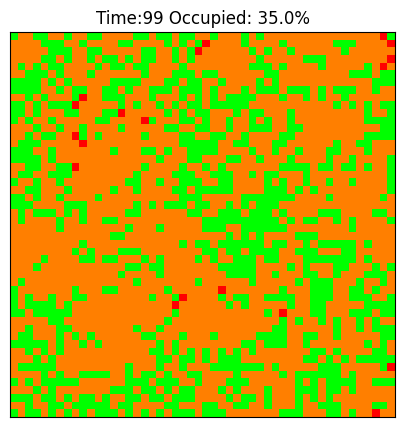

In [40]:
# Ex. 7.2 here
#  Suggestions: use a small grid (e.g., 20x20)  and
#               a short animation (100 frames) with interval=0.3, to slow it down so you can inspect its behaviour

class ToggleGrid:
    def __init__(self, n=10):
        """Initialize the model with an n x n grid of zeros."""
        self.grid = np.zeros((n, n), dtype=int)
        self.n = n

    def step(self):
        """Toggle each cell in the grid."""
        self.grid = 1 - self.grid  # Toggle between 0 and 1

    def draw(self, axes=None, step=''):
        """Draw the grid."""
        title = f'Step: {step}'
        plot_2d_array(self.grid, axes=axes, title=title, cmap='Greys')

# Assuming ForestFire and Animation2D classes are defined above

# Initialize the model
#code form Chat-GPT
forest_fire = ForestFireTwo(n=50, p=0.01, f=0.001, q=0.5)

# Create an animation instance
#code form Chat-GPT
animation = Animation2D(forest_fire, frames=100, steps_per_frame=1, figsize=(5, 5))

# Display the animation
#code form Chat-GPT
animation.animate()


### Question 7.3:
In what ways is this model similar to Diffusion and/or Percolation?
What kinds of behaviours might we predict from this more complex model based on what we learned from the simpler Diffusion and/or Precolation models?
Provide concise (brief, point-form) answers below:

#### Answers:
This model is similiar to diffusion and percolation in the sense of spread and fluctuation. <br>
Regarding the quality of spread, models spread information in similar ways. This model grows forested areas and fire propigates outwards from some critical point wich is very similar to how percolation models would also transmit information. Generally diffustion model do not exhibit this feat however similar results can still be obtained through selective filters. <br>
Regarding the quality of fluctuation, models have the ability to flucuate states. When it come to this model it has generally two states (a thrid being empty) a growth state and a purge state. In the growth state nothing is on fire and forest squres prosper. In the purge state, a fire square is gerneated and the surrounding forest in reverted to an empty square propigating from its origin. Diffusion models are similar as data can go through a transfermation (may be gradual) via a filter. The new data would differ from the old and this can be said to be period.

-------------------

# Lab 8:  Temporal Dynamics: Stability and Equilibrium

The [dynamics](https://en.wikipedia.org/wiki/System_dynamics) of a system describe how it changes over time.  In mathematics, we typically express dyanamics with differential equations (i.e., expressing change over time).  In computation, we typically use a simulation model, like the one developed in Lab 7.

Please watch: [Basic System Dyanmics (15 min)](https://youtu.be/qlRM1JlxfkU) for a quick introduction to these concepts.

---------------------
In this lab we will explore the patterns our `ForestFire` model traces out over time.  We'll try to determine if the model is stable or chaotic, whether there are any circumstances where it reaches [equilibirum](https://en.wikipedia.org/wiki/Mechanical_equilibrium)

## Ex. 8.1: Exploratory Analysis
Explore the behaviour of the model we defined above.
 1. Alter the model's initial conditions - how does the behaviour change depending on the initial proportion of forested vs. empty cells?
 2. Alter the regeneration and fire frequency parameters, $p$ and $f$, to see how this changes the model behaviour - how does the behaviour change as you increase or decrease each of these model parameters?

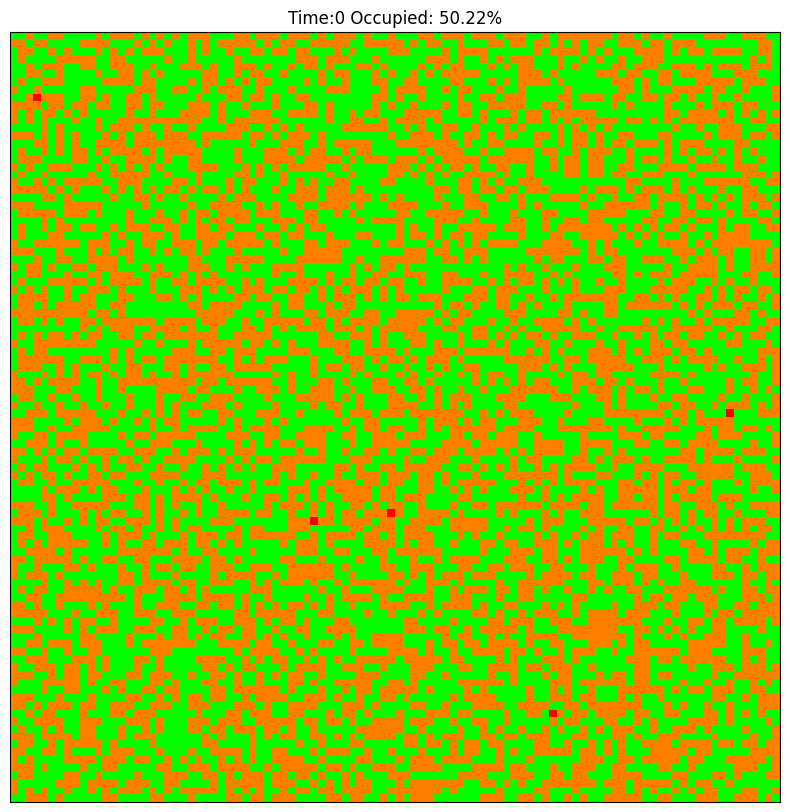

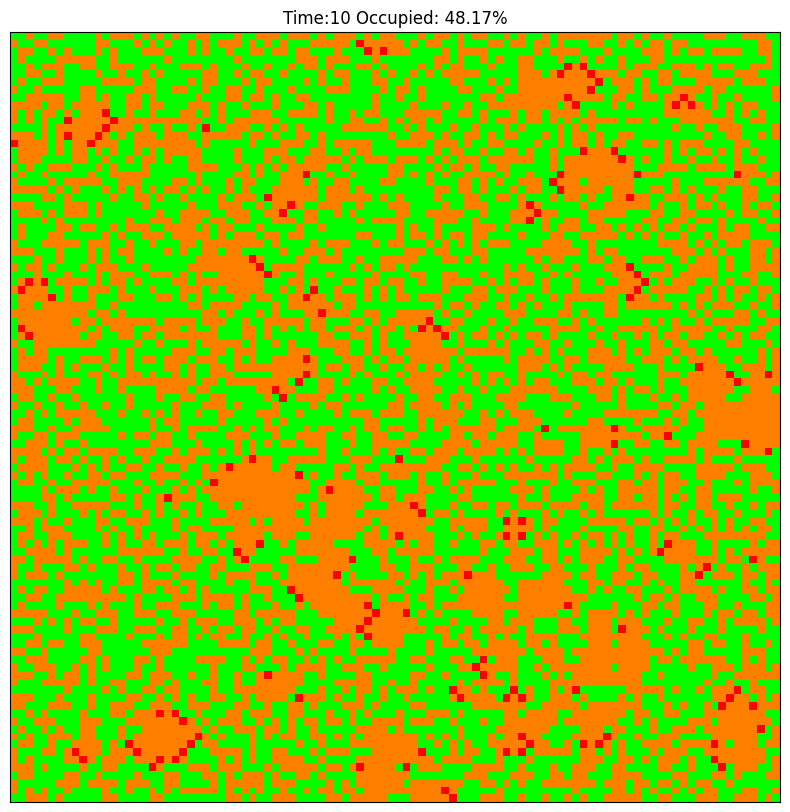

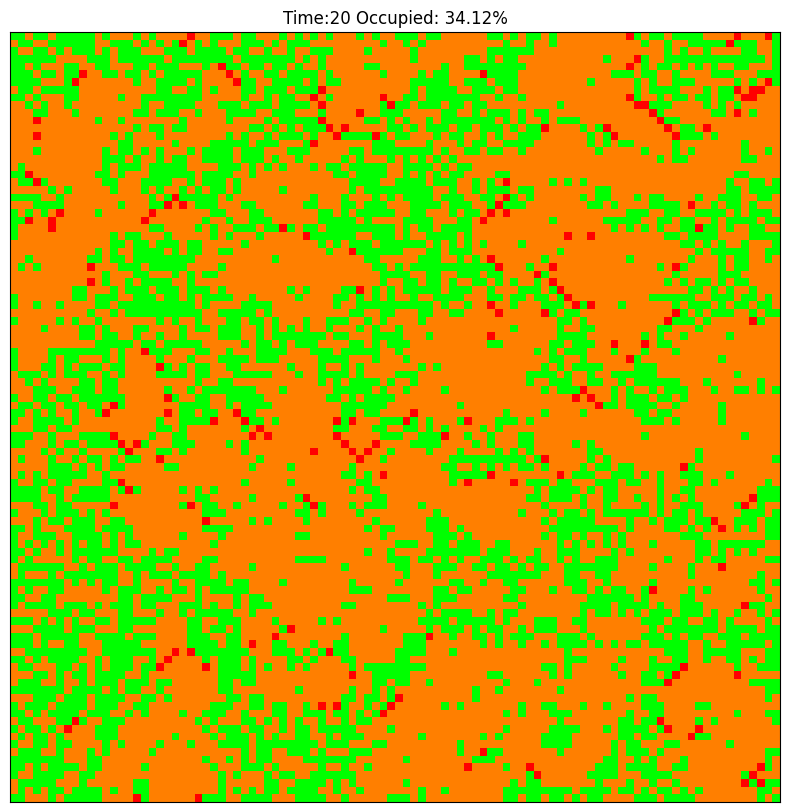

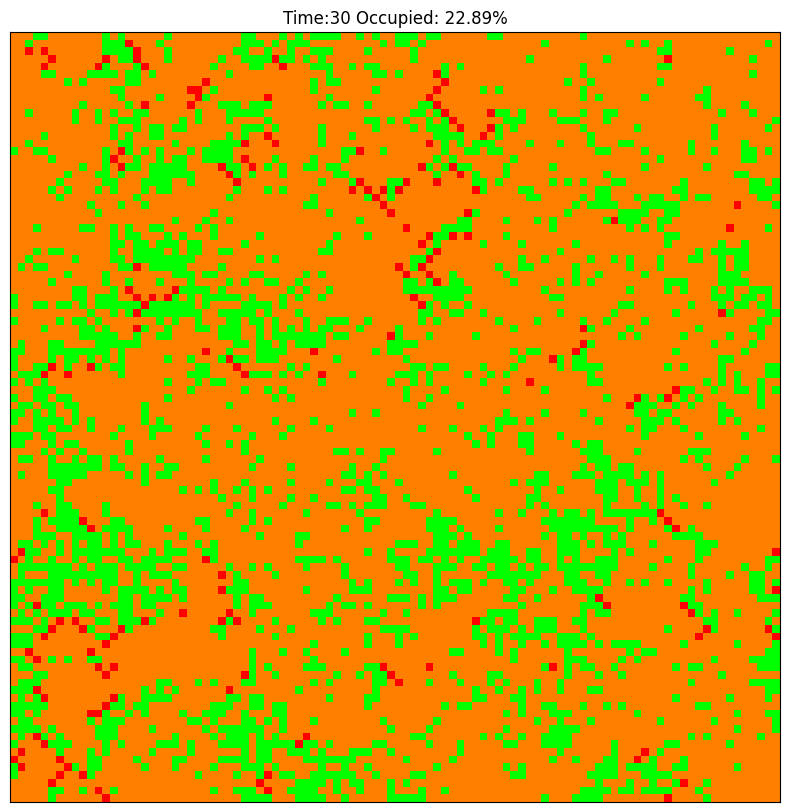

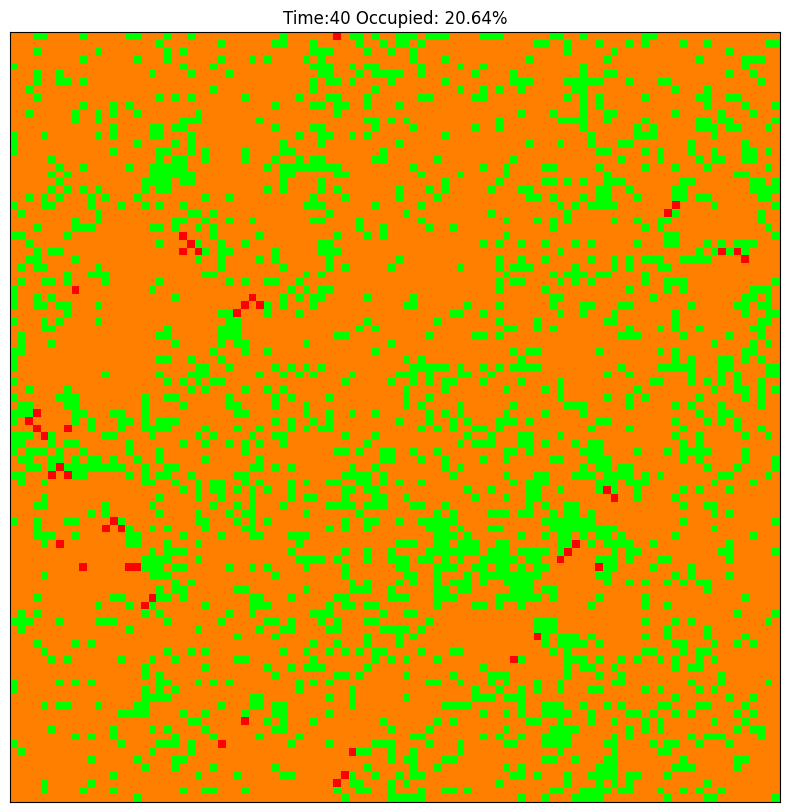

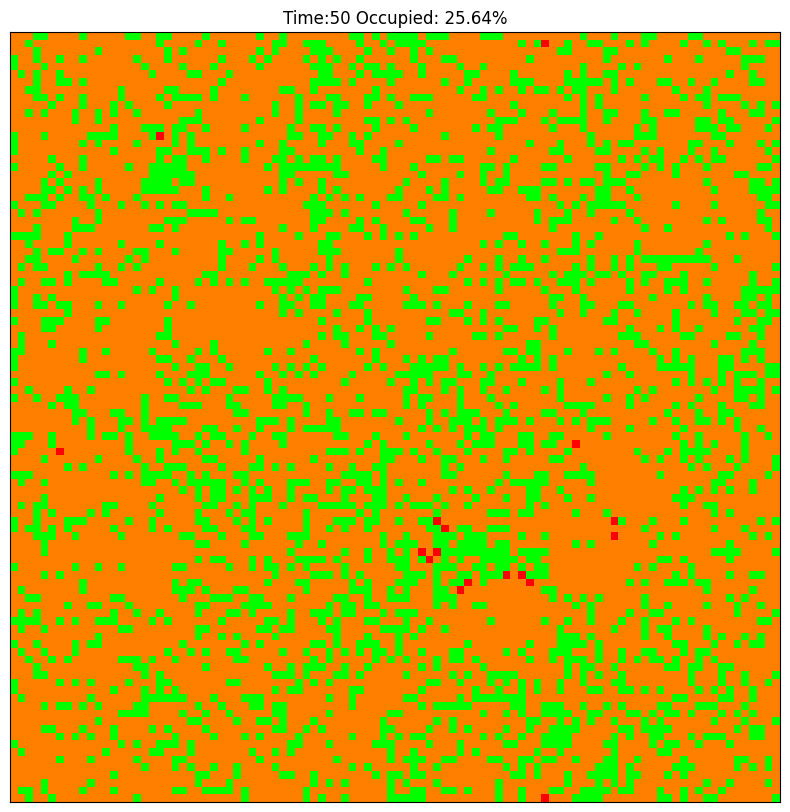

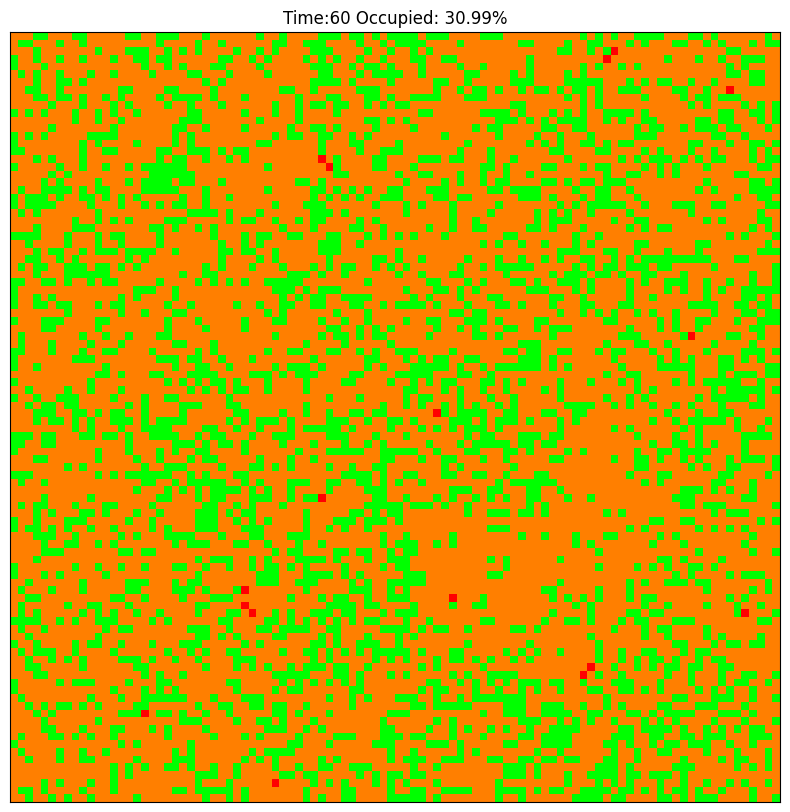

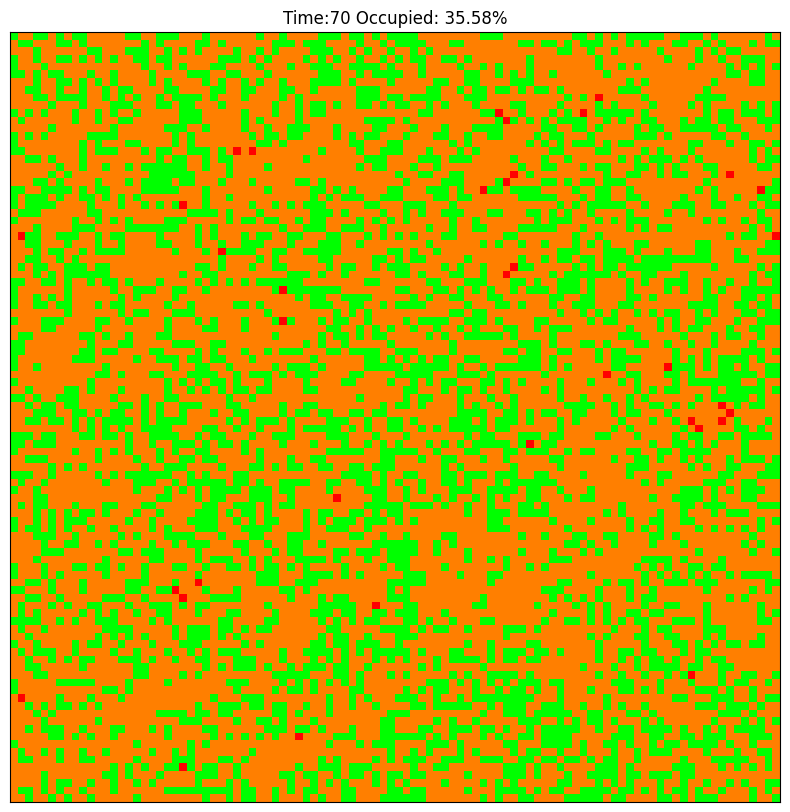

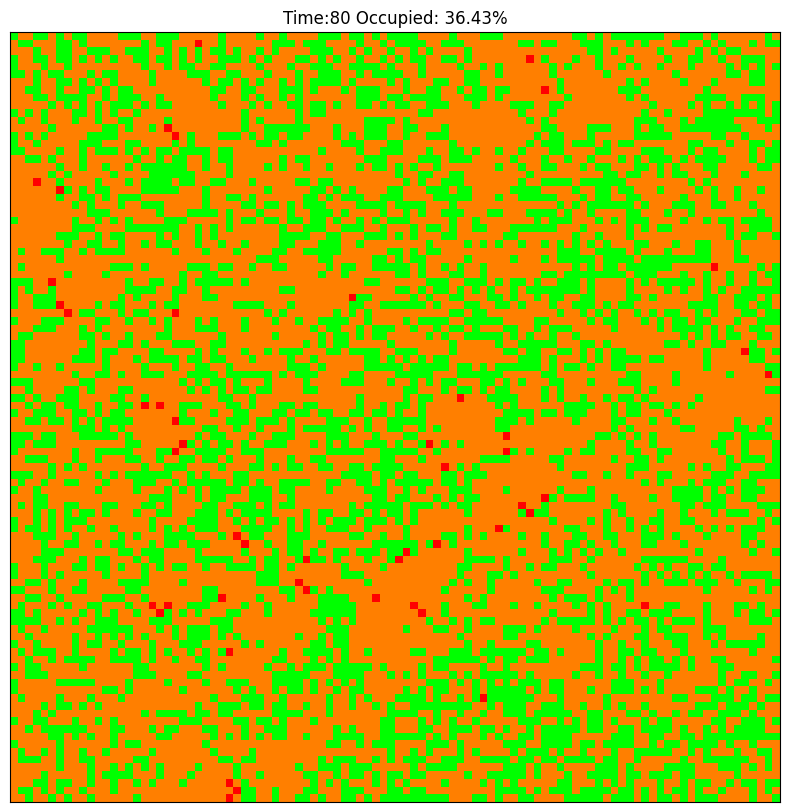

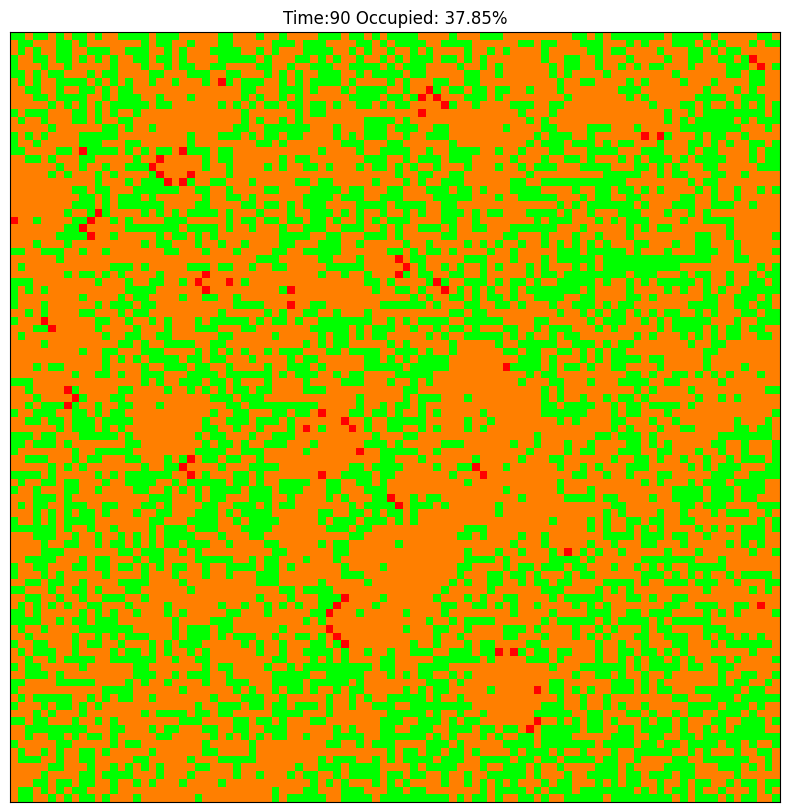

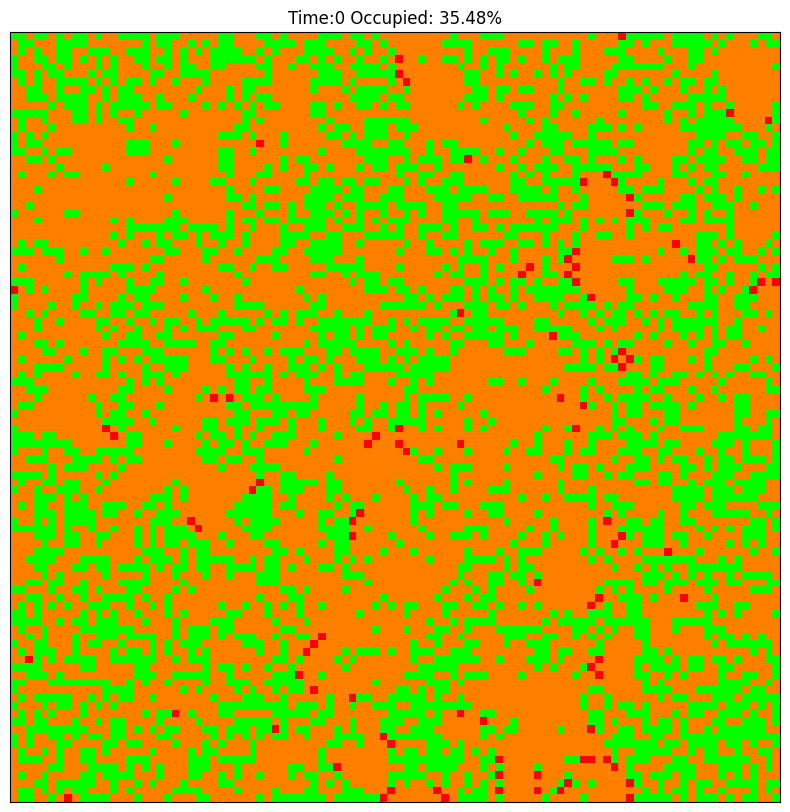

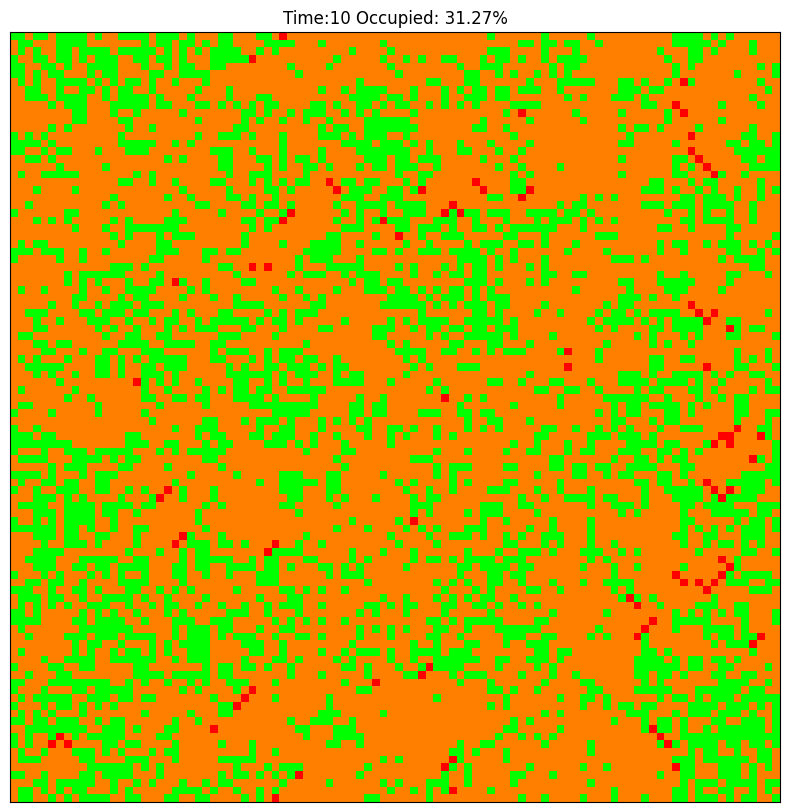

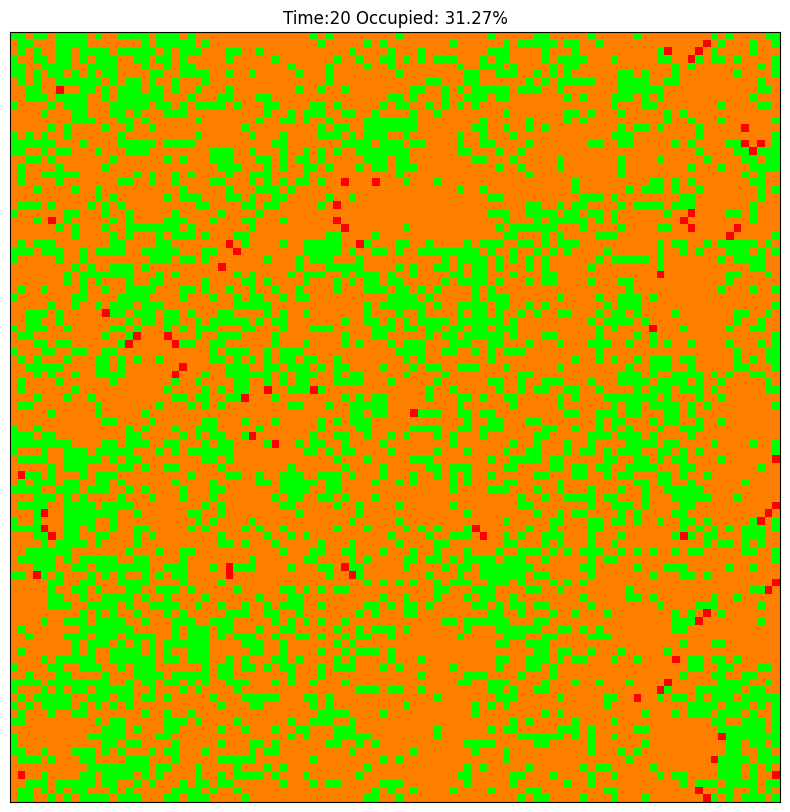

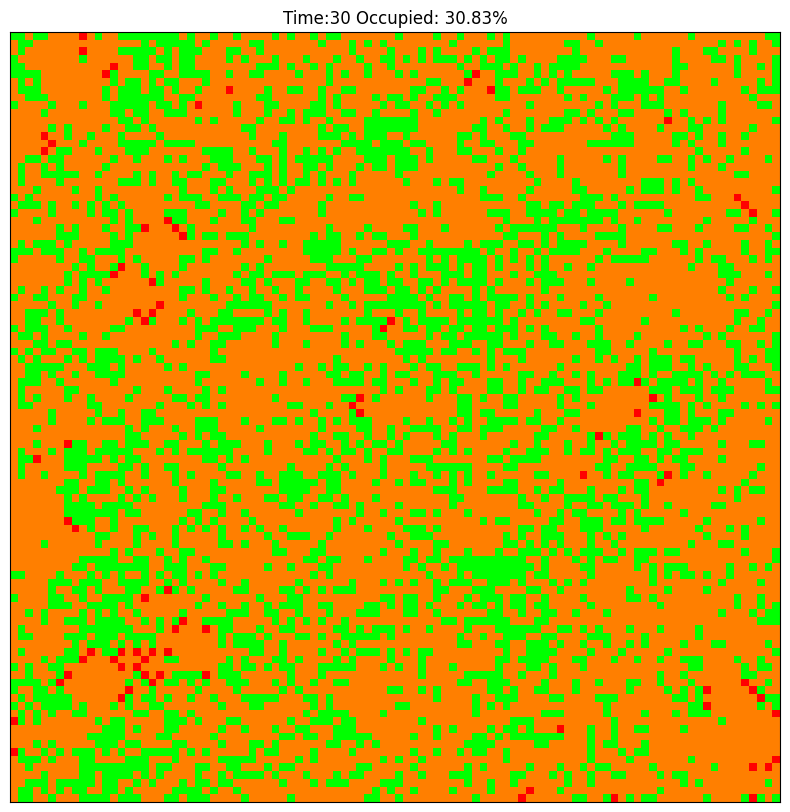

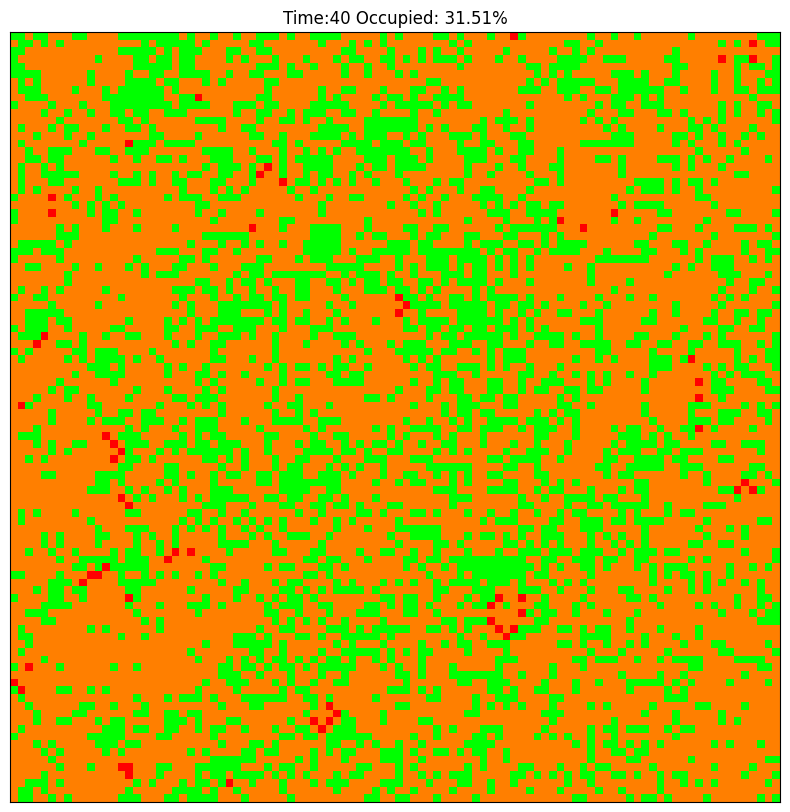

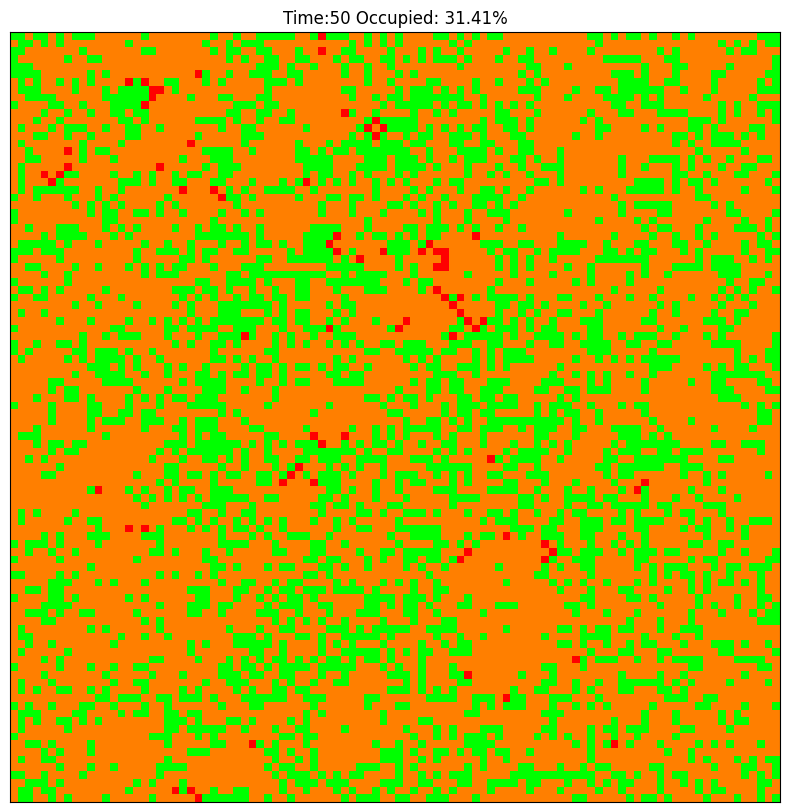

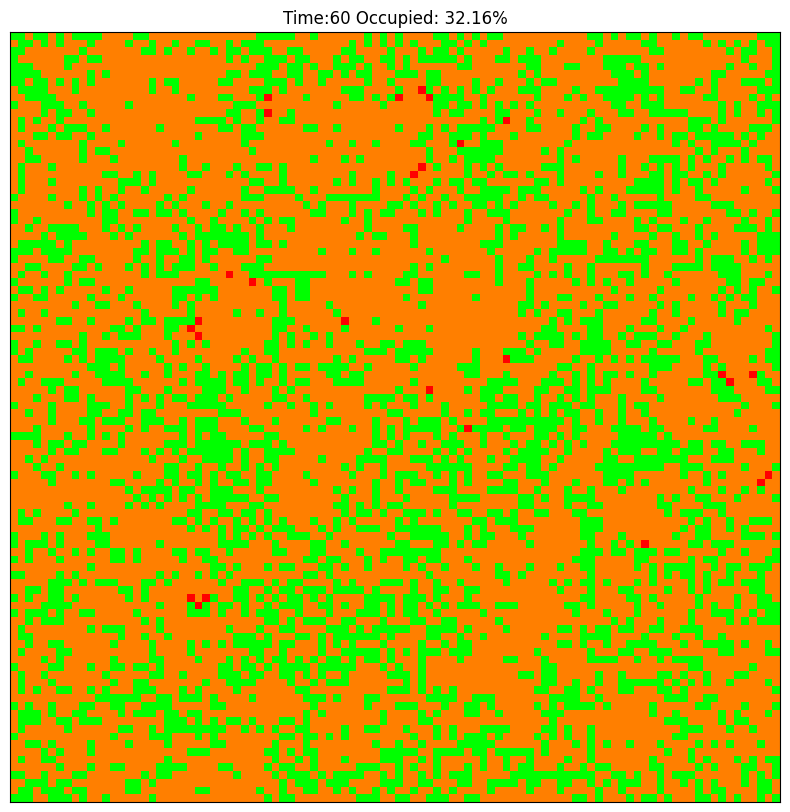

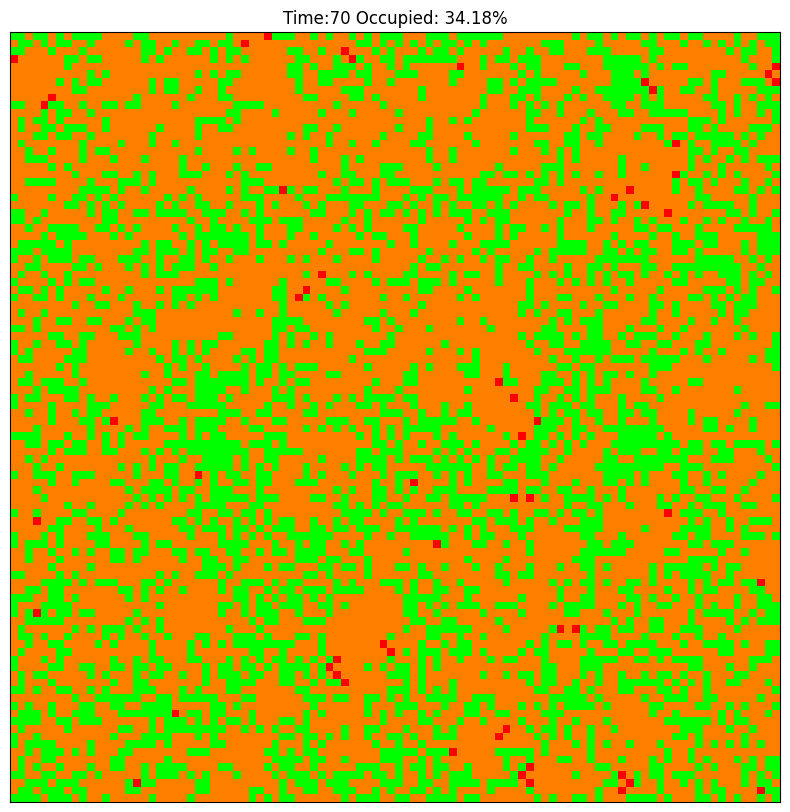

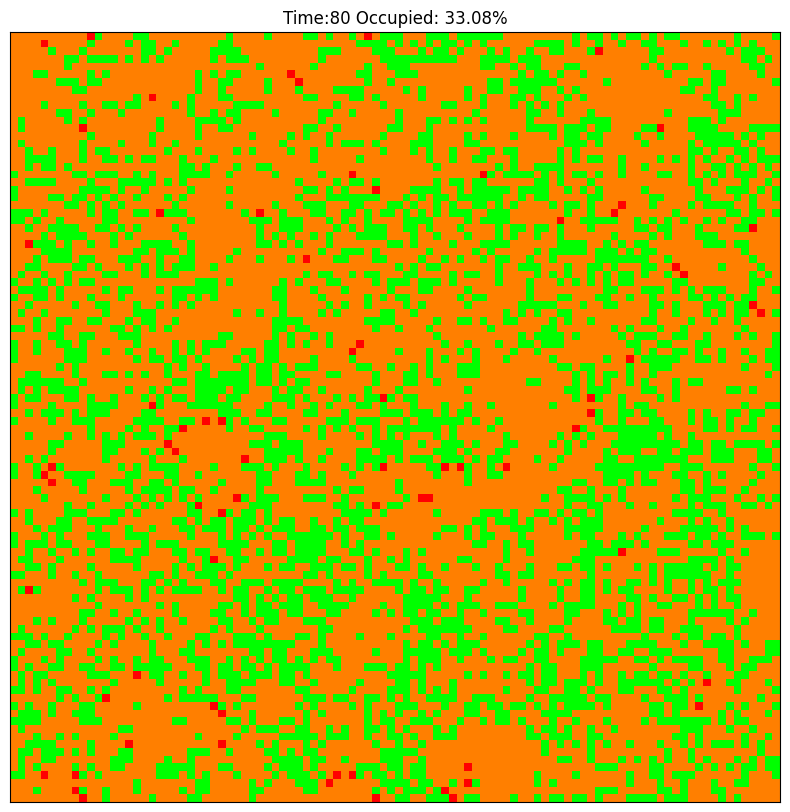

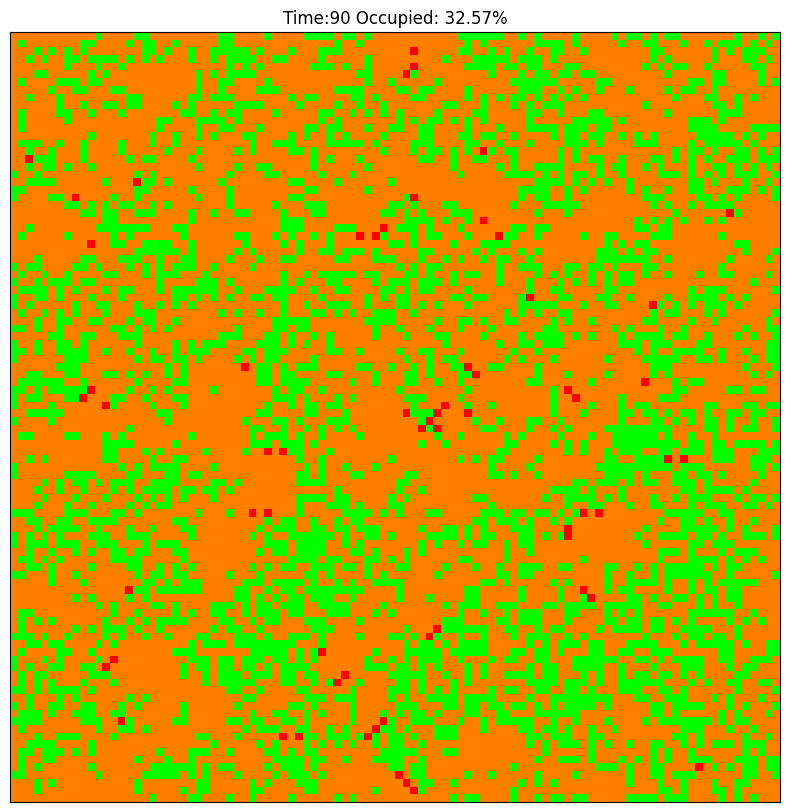

In [41]:
# Ex. 8.1 here
#https://chat.openai.com/share/6eac882a-42c8-4f25-a9d8-52614a79cb2b
#code from Chat gpt
# Example of initializing the model with specific parameters
forest_fire = ForestFireTwo(n=100, p=0.01, f=0.001, q=0.5)

#code from Chat gpt
# Running the model for a fixed number of steps and visualizing the outcome
steps = 100
for step in range(steps):
    forest_fire.step()
    if step % 10 == 0:  # Visualize every 10 steps
        plt.figure(figsize=(10, 10))
        forest_fire.draw(step=str(step))
        plt.show()# sadge



#https://chat.openai.com/share/6eac882a-42c8-4f25-a9d8-52614a79cb2b
#code from chat gpt
class ForestFire_With_New_Beginning(ForestFireTwo):
    """2D Cellular Automaton that simulates a fire-dominated landscape"""
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 2
    cmap = [(1, 0.5, 0), (0, 1, 0), (1, 0, 0)]  # brown, green, red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n=100, p=0.01, f=0.001, q=0.5):
        """Initializes the model with given parameters."""
        self.n = n
        self.p = p
        self.f = f
        self.q = q
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])

    def reset_initial_conditions(self, n=None, p=None, f=None, q=None):
        """Allows resetting the model's initial conditions and parameters."""
        if n is not None:
            self.n = n
        if p is not None:
            self.p = p
        if f is not None:
            self.f = f
        if q is not None:
            self.q = q
            self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (self.n, self.n), p=[q, 1 - q])

    # The rest of the class implementation remains unchanged...

#code form chat gpt
#https://chat.openai.com/share/6eac882a-42c8-4f25-a9d8-52614a79cb2b
#Just for a comarison of another possibility
forest_fire__ = ForestFire_With_New_Beginning()
forest_fire__.reset_initial_conditions(n=150, q=0.6)
for step in range(steps):
    forest_fire.step()
    if step % 10 == 0:  # Visualize every 10 steps
        plt.figure(figsize=(10, 10))
        forest_fire.draw(step=str(step))
        plt.show()# sadge


## Ex. 8.2: Steady State
Many complex systems never achieve a static [equilibirum](https://en.wikipedia.org/wiki/Mechanical_equilibrium), instead their state fluctuates around a value, called an ["attractor"](https://en.wikipedia.org/wiki/Attractor).  A system that is not trending is said to be in ["steady state"](https://en.wikipedia.org/wiki/Steady_state).
Starting from a random initial condition, run the model until it reaches a "steady state" where the number of occupied cells is no longer trending (consistently increasing or decreasing).

Design an experimental setup that allows you to detect when the system is in steady state with respect to the number of forested cells.
This need not be fancy and need not automate the detection of steady state, so long as it provides some output that allows you to detect how long it takes for the system to settle into an equilibrium or cyclical pattern.

Steady state detected at step 200


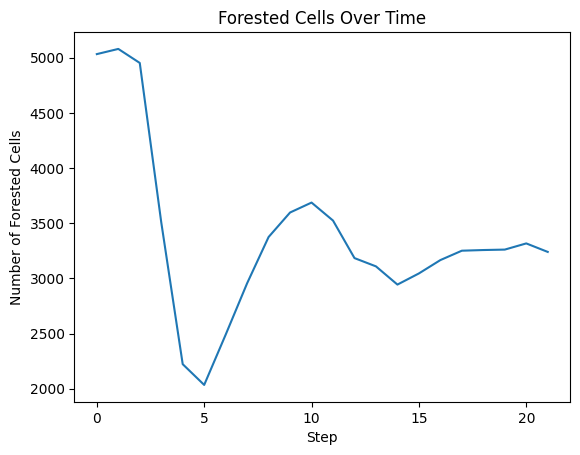

In [42]:
# Ex. 8.2 here
#code for chat gpt
#https://chat.openai.com/share/6eac882a-42c8-4f25-a9d8-52614a79cb2b



class ForestFire_find_steady_state(ForestFire_With_New_Beginning):
    # Class implementation here

    def run_until_steady_state(self, max_steps=1000, steady_state_threshold=0.01, tracking_interval=10):
        """Runs the model until it reaches a steady state or the maximum number of steps."""
        forested_cells_history = [self.num_occupied()]
        for step in range(max_steps):
            self.step()
            if step % tracking_interval == 0:
                current_forested = self.num_occupied()
                forested_cells_history.append(current_forested)
                # Check for steady state over the last few steps
                if len(forested_cells_history) > 5:  # Ensure we have enough points to compare
                    recent_changes = [abs(forested_cells_history[i] - forested_cells_history[i-1]) for i in range(-5, 0)]
                    if max(recent_changes) < steady_state_threshold * self.n * self.n:
                        print(f"Steady state detected at step {step}")
                        return forested_cells_history
        return forested_cells_history

# Example usage
forest_fire = ForestFire_find_steady_state(n=100, p=0.01, f=0.001, q=0.5)
forested_history = forest_fire.run_until_steady_state()

plt.plot(forested_history)
plt.xlabel('Step')
plt.ylabel('Number of Forested Cells')
plt.title('Forested Cells Over Time')
plt.show()



### Question 8.3:
Starting with a uniform random landscape, $q$ = 0.5, find the steady state proportion of forested cells of this system for 3 different combinations of $p$ and $f$, and the approx. number of time steps required to reach steady state.
Fill in the table below with your experimental results:

| p  | f   | steady-state | time steps | Cyclical? |
|----|-----|--------------|------------|-----------|
|0.01|0.001| 240        | 3213          | True      |
|0.5 |0.005| 410            | 3301          | True      |
|1   |0.01 | 210            | 6810          | True      |


In [43]:
#code form chat
#https://chat.openai.com/share/301aa3ab-e2c1-4451-92d3-3b80888da44b
import numpy as np
import matplotlib
from scipy.signal import correlate2d

# Defining the ForestFire classes as provided
class ForestFire:
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 2
    cmap = [(1, 0.5, 0), (0, 1, 0), (1, 0, 0)]  # brown, green, red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

    def __init__(self, n=0, p=0.01, f=0.001, q=0.5):
        self.n = n
        self.p = p
        self.f = f
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])

    def step(self):
        next_state = self.state.copy()
        prob_p = np.random.random(self.state.shape)
        next_state[(self.state == self.EMPTY) & (prob_p < self.p)] = self.OCCUPIED
        prob_f = np.random.random(self.state.shape)
        next_state[(self.state == self.OCCUPIED) & (prob_f < self.f)] = self.FIRE
        next_state[self.state == self.FIRE] = self.EMPTY
        fire_spread = correlate2d(self.state == self.FIRE, self.kernel, mode='same', boundary='wrap') > 0
        next_state[(self.state == self.OCCUPIED) & fire_spread] = self.FIRE
        self.state = next_state

    def num_occupied(self):
        return np.sum(self.state == self.OCCUPIED)

    def pct_occupied(self):
        return self.num_occupied() / self.state.size


class ForestFire_With_New_Beginning(ForestFire):
    def __init__(self, n=100, p=0.01, f=0.001, q=0.5):
        super().__init__(n, p, f, q)

    def reset_initial_conditions(self, n=None, p=None, f=None, q=None):
        if n is not None:
            self.n = n
        if p is not None:
            self.p = p
        if f is not None:
            self.f = f
        if q is not None:
            self.q = q
            self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (self.n, self.n), p=[q, 1 - q])


class ForestFire_find_steady_state(ForestFire_With_New_Beginning):
    def run_until_steady_state(self, max_steps=1000, steady_state_threshold=0.01, tracking_interval=10):
        forested_cells_history = [self.num_occupied()]
        for step in range(max_steps):
            self.step()
            if step % tracking_interval == 0:
                current_forested = self.num_occupied()
                forested_cells_history.append(current_forested)
                if len(forested_cells_history) > 5:
                    recent_changes = [abs(forested_cells_history[i] - forested_cells_history[i-1]) for i in range(-5, 0)]
                    if max(recent_changes) < steady_state_threshold * self.n * self.n:
                        return step, current_forested, self.pct_occupied()
        return None, forested_cells_history[-1], self.pct_occupied()

# Simulating for different combinations of p and f
combinations = [(0.01, 0.001), (0.05, 0.005), (1, 0.01)]
results = []

for p, f in combinations:
    model = ForestFire_find_steady_state(n=100, p=p, f=f, q=0.5)
    step_reached, num_forested, pct_forested = model.run_until_steady_state()
    results.append((p, f, step_reached, num_forested, pct_forested))

print(results)



[(0.01, 0.001, 940, 3205, 0.3205), (0.05, 0.005, 160, 3404, 0.3404), (1, 0.01, 580, 6831, 0.6831)]


## Ex. 8.4: Stability
A system is ["stable"](https://en.wikipedia.org/wiki/Ecological_stability) if it returns to its former steady state after a [disturbance](https://en.wikipedia.org/wiki/Disturbance_(ecology))

A disturbance in our case might be an extreme fire year or an insect outbreak that changes the forest's susceptibility to fire, or several years of reduced regeneration due to a soil fungus killing seedlings.
How could you emulate a disturbance like this in your model?  If you want to modify the model in some way, that's OK, but you may also find ways to emulate a disturbance as an "external forcing function".

Run your model to steady-state, then emulate a major disturbance (over one or more time steps) to "perturb" the system away from its steady state.  Remove the external force and measure how long it takes for the system to return to steady state.

<Figure size 1000x1000 with 0 Axes>

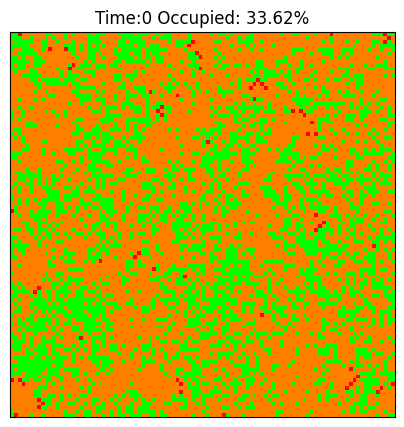

Steady state info (240, 3220, 0.322)
Steady state info (120, 3330, 0.333)


In [44]:
# Ex. 8.4 here
class ForestFireTwo:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1

    #Code from Chat-GPT
    FIRE = 2

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel to detect cardinal neighbourhood on fire
    # Edited to conform with Chat-GPT's answer
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])



    #n=0 might be problematic
    def __init__(self, n=0, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.p = p
        self.f = f

        #Code from Chat-GPT
        self.n = n

        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.state = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])


        # This came from Chat-GPT
        self.kernel = np.array([[0, 1, 0],
                               [1, 0, 1],
                               [0, 1, 0]])

    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
        # Tips: develop 1 rule at a time, in the order above, leaving fire spread (correlation) till last.
        #       Compute each rule in 2 steps: (1) identify which cells the rule applies to; (2) update those cells.
        #       Use the next code block, below, to test as you go.


        # Temporary state to calculate changes without affecting the original state during iteration
        # Create from Chat-GPT
        next_state = self.state.copy()


        # Rule 1: Empty to Occupied
        # Create from Chat-GPT (& --> and)
        prob_p = np.random.random(self.state.shape)#*****
        next_state[(self.state == self.EMPTY) & (prob_p < self.p)] = self.OCCUPIED#******

        # Rule 2: Spontaneous Combustion
        # Create from Chat-GPT
        prob_f = np.random.random(self.state.shape)#*****
        next_state[(self.state == self.OCCUPIED) & (prob_f < self.f)] = self.FIRE#*****

        # Rule 3: Burning cells turn to EMPTY
        # Create from Chat-GPT
        next_state[self.state == self.FIRE] = self.EMPTY#****

        # Rule 4: Spread of Fire
        # Use correlate2d to find cells that are adjacent to fire
        # Create from Chat-GPT
        fire_spread = correlate2d(self.state == self.FIRE, self.kernel, mode='same', boundary='wrap') > 0. #*****
        next_state[(self.state == self.OCCUPIED) & fire_spread] = self.FIRE #****

        # Update the state
        # Create from Chat-GPT
        self.state = next_state

    def num_occupied(self):
        """ return the number of cells occupied by forest """

        #Created from Chat-GPT
        return np.sum(self.state == self.OCCUPIED)# TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.state.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))


#code form chat gpt
#https://chat.openai.com/share/479aa08e-5173-4ccd-bba5-1454b54725cf

class ForestFireMajorDisturbance(ForestFire_find_steady_state, ForestFire_With_New_Beginning, ForestFireTwo):
    """A 2D Cellular Automaton that simulates a fire-dominated landscape,
    with the ability to simulate major disturbances."""

    def simulate_major_disturbance(self, disturbance_intensity=0.25):
        """Simulates a major disturbance in the forest.

        Parameters:
        disturbance_intensity: A float representing the fraction of occupied cells to be set on fire.
        """
        # Calculate the number of cells to affect based on the disturbance intensity
        total_occupied = self.num_occupied()
        cells_to_affect = int(disturbance_intensity * total_occupied)

        # Randomly select cells_to_affect number of cells that are currently OCCUPIED to set on fire
        occupied_indices = np.argwhere(self.state == self.OCCUPIED)
        indices_to_affect = np.random.choice(len(occupied_indices), cells_to_affect, replace=False)

        # Set the selected cells on fire
        for index in indices_to_affect:
            self.state[tuple(occupied_indices[index])] = self.FIRE
plt.figure(figsize=(10, 10))
forest_fire_simulation = ForestFireMajorDisturbance(n=100, p=0.01, f=0.001, q=0.5)

    # Run the simulation until it reaches a steady state or a maximum number of steps
    # You can adjust max_steps and steady_state_threshold as needed
forest_fire_simulation.run_until_steady_state(max_steps=1000, steady_state_threshold=0.01, tracking_interval=10)

animation = Animation2D(forest_fire_simulation, frames=1, steps_per_frame=1, figsize=(5, 5))
animation.animate()
forest_fire_simulation.simulate_major_disturbance()

print("Steady state info", forest_fire_simulation.run_until_steady_state())
forest_fire_simulation_two  = ForestFireMajorDisturbance(n=100, p=0.01, f=0.001, q=0.5)
forest_fire_simulation_two.run_until_steady_state()
print("Steady state info", forest_fire_simulation_two.run_until_steady_state())

### Question 8.4:
Does the model tend to return to the same steady-state, or does the attractor move to a different value?
How long does it take for the model to return to steady-state dynamics?
Does it appear to matter to these results how large the disturbance is?
What does that tell you about the number of "attractors" in this system?

#### Answers:It Usually takes a little of 3000 steps to return to a steady state often a different one. You can tell its different based on the amout of forest area (the firest number).The large disterbance does not seem to play a significant role. The "attractors" in the "system" are about 3200 steps and a forested area of 310.


-----------------

# Lab 9: Patch Size Distribution

The spatial patterns that emerge from this model tends to be landscapes with patches of forested and un-forested land of varying size.  A question naturally arises about this pattern:
  * what is the size of patches created by fire?
    This will alos tell us something about forest [fragmentation](https://en.wikipedia.org/wiki/Habitat_fragmentation), which impacts wildlife habitat, for example.

Notice that rather than a single number, we will get a [distribution](https://en.wikipedia.org/wiki/Probability_distribution) of values for patch sizes.  The shape of this distribution emerges from the system dynamics, and serves as a way to compare our model results with empirical observations of patch-size distributions in real ecosystems.

In this lab we will explore the spatial patterns our `ForestFire` model makes.  We'll ask if these patterns have a [heavy-tail distribution](https://en.wikipedia.org/wiki/Heavy-tailed_distribution) and thus exhibit [self-organizing criticality](https://en.wikipedia.org/wiki/Self-organized_criticality)

### Identifying Contiguous Patches

This is a surprisingly challenging problem to solve in the general case given how good our visual system is at identifying them!
The idea I had here was to start by giving each forested cell a unique value, then "grow" patches by allowing the smallest of these unique values to propagate to neighbouring cells.  Repeat until the propagation is finished.  In the end, all the cells in each contiguous patch have the same, unique identifier.
Notice that this is a modified diffusion / percolation algorithm - they are actually useful!

In [45]:
neighbourhood = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])
centre = tuple(d // 2 for d in neighbourhood.shape)


def max_neighbour(a):
    """ Return the largest non-zero neighbourhood value or 0 if centre cell is a zero """
    assert a.shape == neighbourhood.shape
    p = a * neighbourhood
    return 0 if a[centre]==0 else np.max(p[p > 0])

assert max_neighbour(np.array([[1, 2, 3], [0, 1, 0], [1, 2, 3] ])) == 2
assert max_neighbour(np.array([[1, 2, 3], [0, 0, 0], [1, 2, 3] ])) == 0
assert max_neighbour(np.array([[1, 0, 1], [0, 2, 0], [1, 0, 1] ])) == 2

def consolidate(array):
    """ return copy of array with adjacent cells consolidated into a patch with the lowest value among occupied neighbours """
    rows, cols = array.shape
    array = np.pad(array, 1, mode='wrap')  # wraps edges
    k = neighbourhood.shape[0]
    return np.array([
        [max_neighbour(array[row:row + k, col:col + k]) for col in range(cols)]
        for row in range(rows)
    ], dtype=np.uint)

def patchify(array, patch_category):
    """ Return an array with each contiguous patch identified by a unique integer
    array:  array of int categorical values.
    category: the category value to identify patches for.

    return: array of same shape with a unique value identifying cells in each patch and zeros elsewhere.
    """
    patches = np.zeros(array.shape, dtype=np.uint)
    # assign each cell that falls in a patch a unique number, 1 .. N
    patches[array == patch_category] = range(100, len(array[array == patch_category]) + 100)

    patches_growing = True
    while patches_growing:
        prev_patches = patches
        patches = consolidate(prev_patches)
        patches_growing = np.any(patches != prev_patches)  # patches are growing until consolidate algorithm stabilizes.

    return patches

Patch id's: [100 111 123 124]


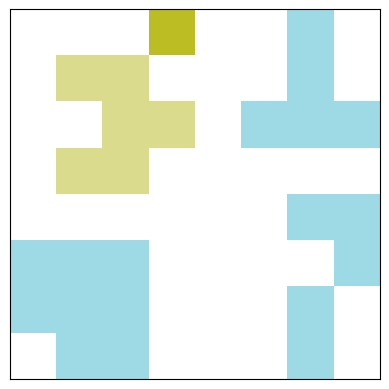

In [46]:
# test patchify
a = np.array([
    [0, 0, 0, 1, 5, 0, 1, 0],
    [0, 1, 1, 0, 5, 0, 1, 0],
    [0, 0, 1, 1, 5, 1, 1, 1],
    [0, 1, 1, 0, 5, 0, 0, 0],
    [0, 0, 0, 0, 5, 0, 1, 1],
    [1, 1, 1, 0, 5, 0, 0, 1],
    [1, 1, 1, 0, 5, 0, 1, 0],
    [0, 1, 1, 0, 5, 0, 1, 0],
], dtype=np.uint)
pch = patchify(a, 1)
plot_2d_array(pch)
print("Patch id's:", np.unique(pch[pch>0]))

## Ex. 9.1 Patch Size Distribution

Run your model to steady-state, and `patchify` the model state.
You might want to plot these beside each other to verify that `patchify` is working as expected.

With a unique "patch id" assigned to each patch, we can tally up the size of each patch simply by counting the number of cells for each unique id.  Important: be sure to exclude the value zero - these are empty cells do not represent a patch!

*Tip*: use [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), with `return_counts=True`, which does exactly the job we want.  It will return 2 arrays with the unique patch id and the matching patch size for each patch.

18


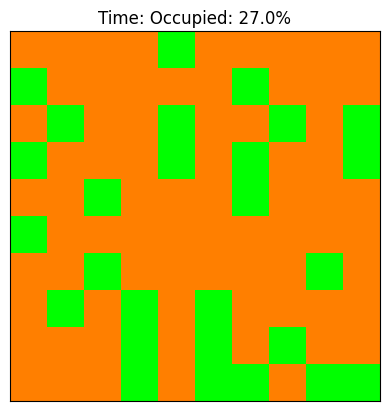

In [47]:
# Ex. 9.1 here
# from chat gpt
#https://chat.openai.com/share/9abc8d07-aee3-457c-b969-e593e45a9868 #fail
#https://chat.openai.com/share/ae5b65dc-eac3-491b-ac2a-9bf7567b19ef

class New_Forest_Fire_with_Patches(ForestFireTwo):
    def get_patch_sizes(self):
        """
        Calculates the sizes of all patches within the forest state.
        A patch is defined as all of the forest squares connected by their cardinal sides.
        """
        def dfs(x, y, visited):
            """
            Depth-first search helper function to calculate the size of a patch.
            """
            if x < 0 or x >= self.n or y < 0 or y >= self.n:  # Check bounds
                return 0
            if visited[x, y] or self.state[x, y] != self.OCCUPIED:  # Check if visited or not occupied
                return 0
            visited[x, y] = True  # Mark as visited
            size = 1  # Include current cell
            directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Cardinal directions
            for dx, dy in directions:
                size += dfs(x + dx, y + dy, visited)
            return size

        visited = np.zeros_like(self.state, dtype=bool)
        patch_sizes = []

        for i in range(self.n):
            for j in range(self.n):
                if self.state[i, j] == self.OCCUPIED and not visited[i, j]:
                    patch_size = dfs(i, j, visited)
                    if patch_size:  # If a non-zero patch is found
                        patch_sizes.append(patch_size)

        return patch_sizes

    def count_patches(self):
        """
        Counts the number of patches in the model.
        A patch is defined as all of the forest squares connected by their cardinal sides.
        """
        def dfs(x, y, visited):
            """
            Depth-first search to mark all cells in the same patch as visited.
            """
            if x < 0 or x >= self.n or y < 0 or y >= self.n:  # Check bounds
                return
            if visited[x, y] or self.state[x, y] != self.OCCUPIED:  # Check if visited or not forest
                return
            visited[x, y] = True  # Mark as visited
            directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Cardinal directions
            for dx, dy in directions:
                dfs(x + dx, y + dy, visited)

        visited = np.zeros_like(self.state, dtype=bool)
        patches = 0
        for i in range(self.n):
            for j in range(self.n):
                if self.state[i, j] == self.OCCUPIED and not visited[i, j]:
                    dfs(i, j, visited)
                    patches += 1
        return patches

# Testing the count_patches method
n = 10  # Size of the forest
forest_fire_model = New_Forest_Fire_with_Patches(n=n, q=0.4)  # Initialize model with a certain density of OCCUPIED cells
patches_count = forest_fire_model.count_patches()  # Count the number of patches

forest_fire_model.draw()

print(patches_count)

## Ex. 9.2 Patch Size frequency distribution

Once you have an array of patch-size counts, construct the distribution of patch sizes.
  * you may use `empericaldist.PDF` as shown in the textbook and `complex-colab` notebook; OR
  * you may use the `FrequencyDist` class we developed in class (copy it from the course notebook); OR
  * you can do the frequency counting yourself - again, `np.unique` could be used, for example to tally up the number of patches in each size class.

patches count: 1121
patches sizes: [1, 3, 1, 1, 13, 1, 9, 1, 3, 7, 5, 4, 1, 1, 2, 2, 1, 4, 8, 1, 2, 1, 1, 3, 1, 1, 4, 1, 5, 1, 1, 3, 1, 1, 4, 1, 36, 2, 9, 1, 1, 3, 1, 1, 1, 2, 8, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 3, 1, 1, 3, 1, 2, 4, 1, 1, 1, 3, 4, 3, 2, 1, 3, 1, 10, 1, 1, 4, 1, 14, 1, 6, 4, 8, 4, 1, 2, 3, 1, 1, 1, 10, 4, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 6, 14, 1, 1, 3, 2, 1, 1, 10, 4, 27, 11, 4, 1, 5, 2, 1, 1, 3, 1, 7, 7, 1, 4, 1, 1, 1, 5, 2, 4, 4, 1, 6, 1, 1, 3, 4, 1, 1, 1, 1, 3, 1, 3, 1, 2, 4, 1, 1, 1, 16, 2, 1, 2, 27, 1, 2, 3, 2, 9, 19, 1, 5, 9, 1, 7, 1, 1, 12, 1, 1, 2, 1, 42, 1, 1, 1, 1, 13, 1, 21, 2, 1, 5, 3, 2, 1, 2, 1, 2, 2, 2, 1, 8, 2, 5, 2, 1, 4, 5, 1, 1, 1, 1, 4, 1, 17, 3, 1, 1, 1, 1, 2, 9, 1, 2, 2, 1, 2, 6, 2, 1, 3, 3, 1, 1, 6, 2, 1, 2, 10, 1, 6, 9, 2, 4, 2, 7, 4, 1, 1, 4, 12, 3, 1, 1, 2, 1, 1, 14, 1, 9, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 6, 1, 2, 1, 10, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 2, 1, 7, 2, 2, 1, 13, 3, 4, 1, 7, 1, 22, 1, 1, 1, 3, 1, 5,

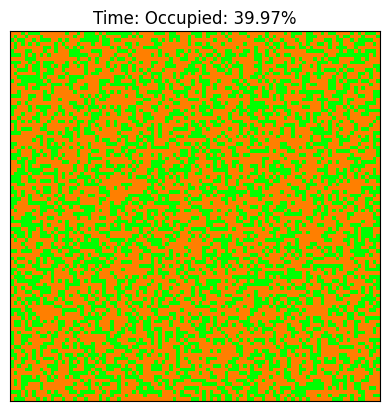

In [62]:
# Ex. 9.2 here
#chat gpt
#https://chat.openai.com/share/ae5b65dc-eac3-491b-ac2a-9bf7567b19ef
n = 10  # Size of the forest
forest_fire_model = New_Forest_Fire_with_Patches(n=100, q=0.4)  # Initialize model with a certain density of OCCUPIED cells
patches_count = forest_fire_model.count_patches()  # Count the number of patches
patches_counts = forest_fire_model.get_patch_sizes()

forest_fire_model.draw()

print("patches count:", patches_count)
print("patches sizes:", patches_counts)

## Ex. 9.3 Heavy-tailed distribution?

Create a plot of the patch size distribution as a bar-chart or a line-graph, both on a linear and log-log scale, similar to the example in Ch. 10.5
Optional: plot the -1 slope line in log-log space on same chart.  Code for this can be found in the Sandpile notebook.

[1, 3, 1, 1, 13, 1, 9, 1, 3, 7, 5, 4, 1, 1, 2, 2, 1, 4, 8, 1, 2, 1, 1, 3, 1, 1, 4, 1, 5, 1, 1, 3, 1, 1, 4, 1, 36, 2, 9, 1, 1, 3, 1, 1, 1, 2, 8, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 3, 1, 1, 3, 1, 2, 4, 1, 1, 1, 3, 4, 3, 2, 1, 3, 1, 10, 1, 1, 4, 1, 14, 1, 6, 4, 8, 4, 1, 2, 3, 1, 1, 1, 10, 4, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 6, 14, 1, 1, 3, 2, 1, 1, 10, 4, 27, 11, 4, 1, 5, 2, 1, 1, 3, 1, 7, 7, 1, 4, 1, 1, 1, 5, 2, 4, 4, 1, 6, 1, 1, 3, 4, 1, 1, 1, 1, 3, 1, 3, 1, 2, 4, 1, 1, 1, 16, 2, 1, 2, 27, 1, 2, 3, 2, 9, 19, 1, 5, 9, 1, 7, 1, 1, 12, 1, 1, 2, 1, 42, 1, 1, 1, 1, 13, 1, 21, 2, 1, 5, 3, 2, 1, 2, 1, 2, 2, 2, 1, 8, 2, 5, 2, 1, 4, 5, 1, 1, 1, 1, 4, 1, 17, 3, 1, 1, 1, 1, 2, 9, 1, 2, 2, 1, 2, 6, 2, 1, 3, 3, 1, 1, 6, 2, 1, 2, 10, 1, 6, 9, 2, 4, 2, 7, 4, 1, 1, 4, 12, 3, 1, 1, 2, 1, 1, 14, 1, 9, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 6, 1, 2, 1, 10, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 2, 1, 7, 2, 2, 1, 13, 3, 4, 1, 7, 1, 22, 1, 1, 1, 3, 1, 5, 16, 4, 5, 4, 6, 1, 2, 1, 3, 7, 1, 

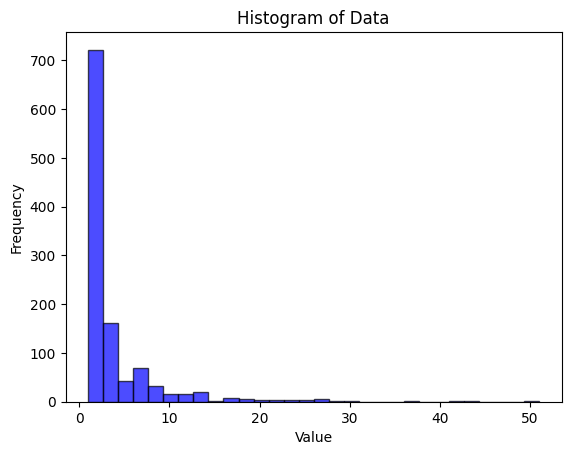

In [65]:
print(patches_counts)
#idksssss = patches_counts.sort()
#rint(idksssss)
plt.hist(patches_counts, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

### Question 9.4

Does the patch size distribution appear to follow the power law?
Does it show any signs of being a "heavy-tailed" distribution?
If it does, what might the implications be for our understanding of the dynamics of real forest ecosystems?

#### Answers
Yes, it follows powers law. It does not show much of being a heavy tailed distrabution. The implications are jus that understanding that forsts are likly to me made up of alot os small patches and few large patches. Forest ecosystems are like designed with "patch" dynamic in mind. Other orgaisms are likely to use this system to support their wellbeing and safetly from predators.


---------------------

# Lab 10:  Fractal Dimension

I highly recommend you start with this [**_2Blue1Brown Video_**](https://youtu.be/gB9n2gHsHN4), if you've not yet seen it.

-----------------
In this lab we will calculate the [fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension) of the forested areas thatour `ForestFire` model generates.

## Ex. 10.1 Box Counting

We'll use the [box counting](https://en.wikipedia.org/wiki/Box_counting) algorithm, which, in essence, estimates how the measured amount of forested area scales at different sized counting grids (2D rulers).  You are welcome to pilfer the `box_count` code developed for measuring fractal dimension in the **Precolation** model.

Run your model forward to steady-state, and use the box counting algorithm to estimate how the pattern of forested patches scales.  The result here show how the count of "forested" cells scales with the size of the "box" (grid cell) used to do the counting.
Just looking at the results, do you think this is closer to a linear or a squared scaling factor?

In [50]:
# Ex. 10.1 here

## Ex. 10.2  Estimate Fractal Dimension

If we plot the count of forested cells versus the size of the "box" on a log-log scale, the slope estimates the fractal dimension.

Estimate the slope of your box-count data using a log-log linear regression (again, feel free to pilfer the `log_slope` function).
Plot the graph that shows the box-count data in relation to a simple linear and square scaling relation (again, pilfer code as needed).

In [51]:
# Ex. 10.2 here

## Ex. 10.3  Scaling Experiment

In our study of Percolation patterns, we plotted the scaling factor and fractal dimension to visualize how the pattern scales compared to simple linear and square scaling.  We set up an experiment to explore how fractal dimension changed for different model paraemter values, and to idenify a critical values where [phase transitions](https://en.wikipedia.org/wiki/Phase_transition) occur.

Repeat these experiments for the `ForestFire` model.  Again, you may adapt the code developed for Percolation.

In [52]:
# Ex. 10.3 here

### Question 10.4:
How does the fractal dimension change for different values of $p$ and $f$?
Does there appear to be a critical value where the fractal dimension goes through a phase change, like we saw for Percolation?
What conclusions might your draw about the complexity of forest edges in real forest ecosystems?  How does this compare the the man-made edges that typically result from industrial logging?

#### Answers: